# Setup

In [1]:
seed = 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
#*************************************************************
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
#*************************************************************
import keras
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.initializers import Constant
from keras.utils import np_utils
from keras import backend as K
#*************************************************************
import tensorflow as tf
from tensorflow.keras.layers import Embedding
print(tf.__version__)
#*************************************************************
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
# kf = KFold(n_splits = 2, random_state = seed, shuffle = True)

#*************************************************************
# Parameters
#*************************************************************
embedding_dimension = 300
vocabulary_size     = 30000
max_length          = 250
# number of documents (paragraphs or sentences per author)
num_docs            = 7000
# num_docs            = 4500
# num_docs            = 15000
# num_docs            = 20000
doc_separator = "\n\n"
# doc_separator = "."
min_length          = 50

OOV_tok             = '<OOV>'
truncate_type       = 'post'
padding_type        = 'post'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2.3.0


# Accessing data from google drive

In [2]:
# storing path variables
# Isha paths
path_glove, path_books, path_models, path_weights = "/content/drive/MyDrive/NLPRutgers_Project/Glove/glove.6B.300d.txt", "/content/drive/MyDrive/NLPRutgers_Project", '/content/drive/MyDrive/NLPRutgers_Project/saved_models', "/content/drive/MyDrive/NLPRutgers_Project/saved_models/weights"
# path_glove, path_books, path_models, path_weights = "/content/drive/MyDrive/NLPRutgers_Project/Glove/glove.6B.100d.txt", "/content/drive/MyDrive/NLPRutgers_Project", '/content/drive/MyDrive/NLPRutgers_Project/saved_models', "/content/drive/MyDrive/NLPRutgers_Project/saved_models/weights"

# Naren paths
# path_glove, path_books, path_models, path_weights = "/content/drive/MyDrive/NLP_project_112020/glove.6B.300d.txt", "/content/drive/MyDrive/NLP_project_112020/ld_books", '/content/drive/MyDrive/NLP_project_112020/kfolds', "/content/drive/MyDrive/NLP_project_112020/models"
# path_glove, path_books, path_models, path_weights = "/content/drive/MyDrive/NLP_project_112020/glove.6B.100d.txt", "/content/drive/MyDrive/NLP_project_112020/ld_books", '/content/drive/MyDrive/NLP_project_112020/kfolds', "/content/drive/MyDrive/NLP_project_112020/models"

In [3]:
#*************************************************************
# Mounting the directory
#*************************************************************

from google.colab import drive
drive.mount('/content/drive')


#*************************************************************
# Embedding
#*************************************************************
embeddings_index = {}

with open(path_glove) as f:

    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 400000 word vectors.


In [4]:
#*************************************************************
# Read a book 
#*************************************************************

def read_file(path):
  with open(path, "r", encoding = "ISO-8859-1") as input:

      document_collection = input.read().split(doc_separator)
  return document_collection

# Process it to remove blanks and change case to lowercase

def doc_vocab(filestream):
    file = filestream
    
    collection = []
    index = -1

    for doc in file:
        doc=doc.lower().rstrip()
        collection.append(doc)
        
    return collection

In [5]:
#*************************************************************
# Read a book  with the above function, split it into Paragraphs and create a dataframe consisting of [Author, Paragraph]
#*************************************************************
def book_to_corpus(path, author):

  # reading the file and storing into document_collection

  document_collection = read_file(path)

  # creating a document vocab

  coll = doc_vocab(document_collection)
  

  # dropping paragraphs with length < 50 

  result = []
  for c in coll:
    
    if len(c) > min_length:
      result.append(c)

  # creating a dataframe with colunns "author" and "paragraph"

  df = pd.DataFrame(
    {
        'author': author,
        'paragraph': result
    })

  return df

In [6]:
#******************************************************************
# Calling above function to create dataframes for individual books.
#******************************************************************

# Initializing an array to store short forms of author names
# ACD = Arthur Conan Doyle
# JA  = Jane Austen
# MT  = Mark Twain
# VW  = Virginia Woolf
#******************************************************************
authors_full = ["Arthur Conan Doyle", "Jane Austen", "Mark Twain", "Virginia Woolf"]
authors = ["ACD", "JA", "MT", "VW"]

# for each file creating a df 
df_list = []

# get all the files from the given directory path
from os import listdir
from os.path import isfile, join

onlyfiles = [f for f in listdir(path_books) if isfile(join(path_books, f))]

onlyfiles = sorted(onlyfiles)
print(onlyfiles)

# calling the book_to_corpus function for each file
for index, file in enumerate(onlyfiles):

  # Assiginng author to the file (every 5 books will have same author)
  if 0 <= index <= 5:
    a_i = 0
  elif 6 <= index <= 10:
    a_i = 1
  elif 11 <= index <= 17:
    a_i = 2
  else:
    a_i = 3

  # storing the dataframe for individual books into a list

  df_list.append(book_to_corpus("{}/{}".format(path_books,file), authors[a_i]))


['acd_a_study_in_scarlet.txt', 'acd_return_of_sherlock_holmes.txt', 'acd_rodney_stone.txt', 'acd_the_adventures_of_sherlock_holmes.txt', 'acd_the_hound_of_the_baskervilles.txt', 'acd_the_lost_world.txt', 'ja_emma.txt', 'ja_mansfield_park.txt', 'ja_persuasion.txt', 'ja_pride_and_prejudice.txt', 'ja_sense_and_sensibility.txt', 'mt_a_ct_yankee.txt', 'mt_adventures_of_huckleberry_finn.txt', 'mt_life_in_missisipi.txt', 'mt_the_adventure_of_tom_sawyer.txt', 'mt_the_innocents_abroad.txt', 'mt_the_prince_and_the_pauper.txt', 'vw_haunted_house.txt', 'vw_jacobs_room.txt', 'vw_monday_or_tuesday.txt', 'vw_mrs_dalloway.txt', 'vw_night_and_day.txt', 'vw_orlando.txt', 'vw_room_of_ones_own.txt', 'vw_the_moments_of_being.txt', 'vw_the_voyage_out.txt', 'vw_the_waves.txt', 'vw_the_years.txt', 'vw_three_guines.txt', 'vw_to_the_lighthouse.txt']


In [7]:
#*************************************************************************
# Merging all the individual books to form master dataframe of all books.
#*************************************************************************
df = pd.DataFrame(columns= ["author", "paragraph"])
df = df.fillna(0)

for dfs in df_list:
  df = pd.concat([df, dfs], ignore_index=True)

# Keep 4500 paragraphs for each author. This is so that we have balanced data across different classes.
acd = df[df.author == "ACD"][:num_docs]
ja = df[df.author == "JA"][:num_docs]
mt = df[df.author == "MT"][:num_docs]
vw = df[df.author == "VW"][:num_docs]

# merging the aboce dfs
df = pd.concat([acd, ja, mt, vw], ignore_index=True)

print("Shape of individual dataframe containing books of author Arthur Conan Doyle: ",acd.shape)
print("Shape of individual dataframe containing books of author Jane Austen.      : ",ja.shape)
print("Shape of individual dataframe containing books of author Mark Twain.       : ",mt.shape)
print("Shape of individual dataframe containing books of author Virginia Woolf.   : ",vw.shape)
print(" ")
print("Shape of Master dataframe containing all books                             : ", df.shape)

Shape of individual dataframe containing books of author Arthur Conan Doyle:  (7000, 2)
Shape of individual dataframe containing books of author Jane Austen.      :  (7000, 2)
Shape of individual dataframe containing books of author Mark Twain.       :  (7000, 2)
Shape of individual dataframe containing books of author Virginia Woolf.   :  (7000, 2)
 
Shape of Master dataframe containing all books                             :  (28000, 2)


# Data Preprocessing# 

In [8]:
#*************************************************************
# Making all text into lower case.
#*************************************************************
df['paragraph'] = df['paragraph'].str.lower()

#*************************************************************
# Lemmatization:
#*************************************************************
def getLemmText(text):
 tokens     = word_tokenize(text)
 lemmatizer = WordNetLemmatizer()
 tokens     = [lemmatizer.lemmatize(word) for word in tokens]
 return ' '.join(tokens)

df['paragraph'] = list(map(getLemmText,df['paragraph']))

#*************************************************************
# Stemming:
#*************************************************************
def getStemmText(text):
    tokens  = word_tokenize(text)
    ps      = PorterStemmer()
    tokens  = [ps.stem(word) for word in tokens]
    return ' '.join(tokens)

df['paragraph'] = list(map(getStemmText,df['paragraph']))

In [9]:
df.head()

,author,paragraph
0,ACD,in the year 1878 i took my degre of doctor of ...
1,ACD,the campaign brought honour and promot to mani...
2,ACD,"worn with pain , and weak from the prolong har..."
3,ACD,"i had neither kith nor kin in england , and wa..."
4,ACD,on the veri day that i had come to thi conclus...


# Train - Validation - Test split

In [10]:
#*************************************************************
# Split date to create Train and Test series
#*************************************************************
x_tr, x_tst, y_tr, y_tst = train_test_split( df['paragraph'], df['author'], test_size=0.2, random_state= seed)

# Create Train and Test Dataframe
train_data = pd.DataFrame({ 'author': y_tr, 'paragraph': x_tr } )
test_data = pd.DataFrame({ 'author': y_tst, 'paragraph': x_tst } )

print("Shape of Train data  : ", train_data.shape)
print("Shape of Test data  : ", test_data.shape)




#*************************************************************
# Split train_data into train1_data and val1_data
#*************************************************************
x_tr1, x_val1, y_tr1, y_val1 = train_test_split( train_data['paragraph'], train_data['author'], test_size=0.2, random_state= seed)

# Create Train and Test Dataframe
train1_data = pd.DataFrame({ 'author': y_tr1, 'paragraph': x_tr1 } )
val1_data = pd.DataFrame({ 'author': y_val1, 'paragraph': x_val1 } )

#*************************************************************
# Final Evaluation to be done on these.
#*************************************************************
x_train1  = train1_data["paragraph"]
y_train1  = train1_data["author"]

x_val1    = val1_data["paragraph"]
y_val1    = val1_data["author"]

x_test    = test_data["paragraph"]
y_test    = test_data["author"]
#*************************************************************

#**************************************************************************
# Tokenizing X
#**************************************************************************
tokenizer_train = Tokenizer(num_words=vocabulary_size, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', oov_token=OOV_tok)
tokenizer_train.fit_on_texts(list(x_train1))

x_train1_sequences  = tokenizer_train.texts_to_sequences(x_train1)
x_val1_sequences    = tokenizer_train.texts_to_sequences(x_val1)
x_test_sequences    = tokenizer_train.texts_to_sequences(x_test)
word_index_train1          = tokenizer_train.word_index

print('Vocabulary size:', len(word_index_train1))
dict(list(word_index_train1.items())[0:10])

#**************************************************************************
# Padding X
#**************************************************************************
xtrain1_pad  = sequence.pad_sequences(x_train1_sequences,  maxlen=max_length, padding=padding_type, truncating=truncate_type)
xval1_pad    = sequence.pad_sequences(x_val1_sequences,    maxlen=max_length, padding=padding_type, truncating=truncate_type)
xtest_pad    = sequence.pad_sequences(x_test_sequences,    maxlen=max_length, padding=padding_type, truncating=truncate_type)

#**************************************************************************
# Then we do the same for Y .
#**************************************************************************
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(list(y_train1))
training_label_seq    = np.array(label_tokenizer.texts_to_sequences(y_train1))
validation_label_seq  = np.array(label_tokenizer.texts_to_sequences(y_val1))
test_label_seq        = np.array(label_tokenizer.texts_to_sequences(y_test))

Shape of Train data  :  (22400, 2)
Shape of Test data  :  (5600, 2)
Vocabulary size: 24131


In [11]:
print(x_train1.shape)
print(x_val1.shape)

(17920,)
(4480,)


In [12]:
# helper function to print confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import plotly.graph_objects as go
import matplotlib.pyplot as plt

def plot_mat(test_labels, predicted_labels):
  labs = authors_full
  mat = confusion_matrix(test_labels, predicted_labels)
  plt.figure(figsize=(5,5))
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
              xticklabels=labs, yticklabels=labs)
  plt.xlabel('true label')
  plt.ylabel('predicted label')

# Naive Bayes

Train accuracy of Naive Bayes: 91.93080357142858
Validation accuracy of Naive Bayes: 87.99107142857143
Test accuracy of Naive Bayes: 88.23214285714286
F1 Micro: 0.8799107142857143
F1 Macro: 0.8793890407787146


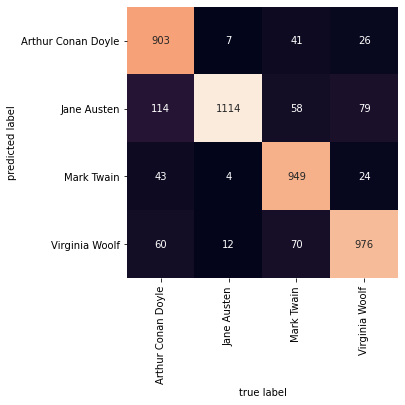

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score

def nb():
  # fit the model using the training data and then predict the targets/labels of test data
  model = make_pipeline(TfidfVectorizer(), MultinomialNB())
  model.fit(x_train1, y_train1)
  labels = model.predict(x_val1)
  
  acc_nb_train = model.score(x_train1,y_train1)*100
  acc_nb_val = model.score(x_val1,y_val1)*100
  acc_nb_test = model.score(x_test,y_test)*100

  print("Train accuracy of Naive Bayes:",acc_nb_train)
  print("Validation accuracy of Naive Bayes:",acc_nb_val)
  print("Test accuracy of Naive Bayes:",acc_nb_test)
  return labels
pred_labels = nb()
plot_mat(y_val1, pred_labels)

micro_f1 = f1_score(y_val1, pred_labels, labels=None, pos_label=1, average='micro')
macro_f1 = f1_score(y_val1, pred_labels, labels=None, pos_label=1, average='macro')
print("F1 Micro:",micro_f1)
print("F1 Macro:",macro_f1)

In [14]:
#*************************************************************
# Graph of accuracy and loss
#*************************************************************
def graph_plots(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [15]:

# helper function for creating LSTM model architecture
def create_new_model(model_name, embedding_layer, embedding_matrix):
  if model_name == "LSTM_1":
    model = Sequential()
    model.add(embedding_layer)
    model.add(Bidirectional(LSTM(embedding_dimension)))
    model.add(Dense(5))
    model.add(Activation('softmax'))
    

  elif model_name == "LSTM_2":
    model = Sequential()
    model.add(embedding_layer)
    model.add(Bidirectional(LSTM(embedding_dimension)))
    model.add(Dense(embedding_dimension, activation = "relu"))
    model.add(Dense(embedding_dimension, activation = "relu"))
    model.add(Dense(5))
    model.add(Activation('softmax'))

  elif model_name == "LSTM_3":
    model = Sequential()
    model.add(embedding_layer)
    model.add(Bidirectional(LSTM(embedding_dimension)))
    model.add(Dense(embedding_dimension, activation = "relu"))
    model.add(Dropout(0.8))
    model.add(Dense(embedding_dimension, activation = "relu"))
    model.add(Dropout(0.8))
    model.add(Dense(5))
    model.add(Activation('softmax'))

  elif model_name == "LSTM_4":
    model = Sequential()
    model.add(embedding_layer)
    model.add(Bidirectional(LSTM(embedding_dimension)))
    model.add(Dense(embedding_dimension, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(embedding_dimension, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
  print(model.summary())
  return model


In [16]:
def validation(mod, num_epochs, experiment):
  save_dir = path_models

  #**************************************************************************
  # Embedding
  #**************************************************************************
  # Prepare embedding matrix
  hits = 0
  misses = 0
  embedding_matrix = np.random.random((vocabulary_size, embedding_dimension))
  for word, i in word_index_train1.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # Words not found in embedding index will be all random.
          # This includes the representation for  "OOV"
          embedding_matrix[i] = embedding_vector
          hits += 1
      else:
          misses += 1
  print("Converted %d words (%d misses)" % (hits, misses))


  embedding_layer = Embedding(
      input_dim               = vocabulary_size,
      output_dim              = embedding_dimension,
      input_length            = max_length,
      embeddings_initializer  = tf.keras.initializers.Constant(embedding_matrix),
      trainable               = False
  )

  if mod == "LSTM_1":
    mod = create_new_model("LSTM_1", embedding_layer, embedding_matrix)
  elif mod == "LSTM_2":
    mod = create_new_model("LSTM_2", embedding_layer, embedding_matrix)
  elif mod == "LSTM_3":
    mod = create_new_model("LSTM_3", embedding_layer, embedding_matrix)
  elif mod == "LSTM_4":
    mod = create_new_model("LSTM_4", embedding_layer, embedding_matrix)
  else:
    print("User defined error: Model not found!")


  #**************************************************************************
  # Model architecture
  #**************************************************************************

  model = mod

  #**************************************************************************
  # Model compilation
  #**************************************************************************

  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['acc'])
  
  #**************************************************************************
  # Fit the model
  #**************************************************************************
  start_time = datetime.now()
  history = model.fit(xtrain1_pad, training_label_seq, epochs=num_epochs, validation_data=(xval1_pad, validation_label_seq), verbose=2)
  end_time = datetime.now()
  print('Duration of Model fitting : {}'.format(end_time - start_time))
  
  #**************************************************************************
  # Save model weights
  #**************************************************************************

  model.save_weights(experiment)

  #**************************************************************************
  # Graph of accuracy and loss ( Train vs Validation)
  #**************************************************************************
  graph_plots(history, "acc")
  graph_plots(history, "loss")

  #**************************************************************************
  # Model evaluation
  #**************************************************************************

  print("**************************************************************************")
  print("************************************* Metrics ****************************")
  print("**************************************************************************")

  results_train = model.evaluate(xtrain1_pad, training_label_seq)
  results_train = dict(zip(model.metrics_names,results_train))

  results = model.evaluate(xval1_pad, validation_label_seq)
  results = dict(zip(model.metrics_names,results))

  results_test = model.evaluate(xtest_pad, test_label_seq)
  results_test = dict(zip(model.metrics_names,results_test))

  predictions_training=model.predict([xtrain1_pad])
  plot_mat(np.squeeze(training_label_seq), np.argmax(predictions_training,axis=-1))

  micro_f1_training = f1_score(np.squeeze(training_label_seq), np.argmax(predictions_training,axis=-1), labels=None, pos_label=1, average='micro')
  macro_f1_training = f1_score(np.squeeze(training_label_seq), np.argmax(predictions_training,axis=-1), labels=None, pos_label=1, average='macro')

  predictions_validation=model.predict([xval1_pad])
  plot_mat(np.squeeze(validation_label_seq), np.argmax(predictions_validation,axis=-1))

  micro_f1 = f1_score(np.squeeze(validation_label_seq), np.argmax(predictions_validation,axis=-1), labels=None, pos_label=1, average='micro')
  macro_f1 = f1_score(np.squeeze(validation_label_seq), np.argmax(predictions_validation,axis=-1), labels=None, pos_label=1, average='macro')

  predictions_test=model.predict([xtest_pad])
  plot_mat(np.squeeze(test_label_seq), np.argmax(predictions_test,axis=-1))

  micro_f1_test = f1_score(np.squeeze(test_label_seq), np.argmax(predictions_test,axis=-1), labels=None, pos_label=1, average='micro')
  macro_f1_test = f1_score(np.squeeze(test_label_seq), np.argmax(predictions_test,axis=-1), labels=None, pos_label=1, average='macro')


  print("**************************************************************************")

  print("Results Training     :",results_train)
  print("F1 Micro Training    :",micro_f1_training)
  print("F1 Macro Training    :",macro_f1_training)
  print("Results Validation   :",results)
  print("F1 Micro Validation  :",micro_f1)
  print("F1 Macro Validation  :",macro_f1)
  print("Results Test         :",results_test) 
  print("F1 Micro Test        :",micro_f1_test)
  print("F1 Macro Test        :",macro_f1_test)

  print("**************************************************************************")

  return model

# Keras NLP Experiments

Converted 12912 words (11219 misses)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 300)          9000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 600)               1442400   
_________________________________________________________________
dense (Dense)                (None, 5)                 3005      
_________________________________________________________________
activation (Activation)      (None, 5)                 0         
Total params: 10,445,405
Trainable params: 1,445,405
Non-trainable params: 9,000,000
_________________________________________________________________
None
Epoch 1/5
560/560 - 26s - loss: 0.8348 - acc: 0.6609 - val_loss: 0.5527 - val_acc: 0.7933
Epoch 2/5
560/560 - 25s - loss: 0.5161 - acc: 0.8058 - val_loss: 0.5087 - val_acc: 0.8116
Epoch 3/5
560

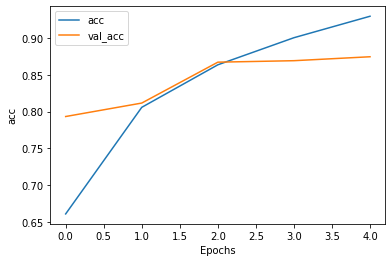

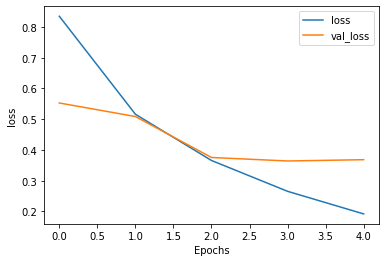

**************************************************************************
************************************* Metrics ****************************
**************************************************************************
175/175 [==============================] - 3s 15ms/step - loss: 0.3417 - acc: 0.8820
**************************************************************************
Results Training     : {'loss': 0.12779520452022552, 'acc': 0.9574218988418579}
F1 Micro Training    : 0.957421875
F1 Macro Training    : 0.9575710600278252
Results Validation   : {'loss': 0.368259459733963, 'acc': 0.8745535612106323}
F1 Micro Validation  : 0.8745535714285714
F1 Macro Validation  : 0.8749129523301264
Results Test         : {'loss': 0.34173277020454407, 'acc': 0.8819642663002014}
F1 Micro Test        : 0.8819642857142858
F1 Macro Test        : 0.8826116776822833
**************************************************************************
*********************************************************

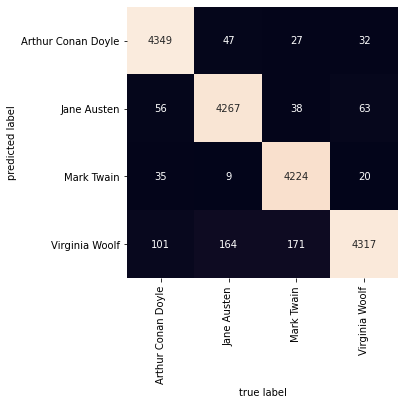

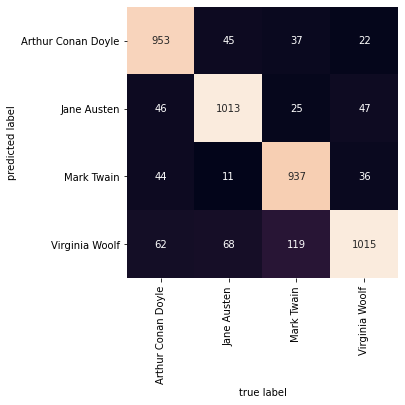

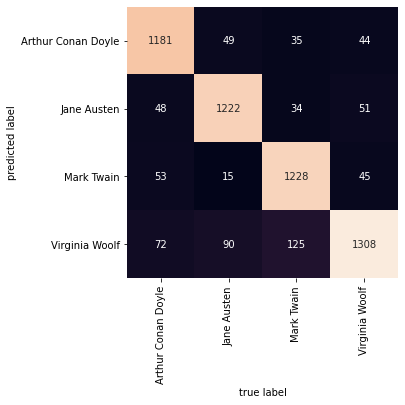

In [17]:
# Experiment 1

start_time = datetime.now()
model_1 = validation("LSTM_1",  num_epochs = 5, experiment = "{}/exp1.h5".format(path_weights))
end_time = datetime.now()
print("**************************************************************************")
print('Duration = {}'.format(end_time - start_time))
print("**************************************************************************")

Converted 12912 words (11219 misses)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 300)          9000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 600)               1442400   
_________________________________________________________________
dense_1 (Dense)              (None, 300)               180300    
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1505      
_________________________________________________________________
activation_1 (Activation)    (None, 5)                 0         
Total params: 10,714,505
Trainable params: 1,714,505
Non-trainable params: 9,000,00

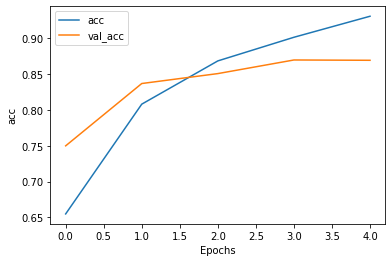

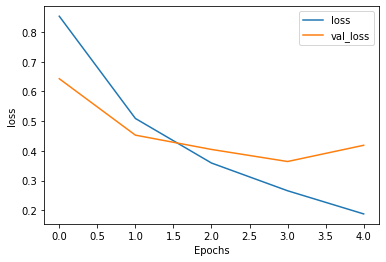

**************************************************************************
************************************* Metrics ****************************
**************************************************************************
175/175 [==============================] - 3s 15ms/step - loss: 0.3962 - acc: 0.8750
**************************************************************************
Results Training     : {'loss': 0.11891108751296997, 'acc': 0.9572544693946838}
F1 Micro Training    : 0.9572544642857143
F1 Macro Training    : 0.9572714943963471
Results Validation   : {'loss': 0.4187566339969635, 'acc': 0.8689731955528259}
F1 Micro Validation  : 0.8689732142857143
F1 Macro Validation  : 0.8690966746536963
Results Test         : {'loss': 0.3962361812591553, 'acc': 0.875}
F1 Micro Test        : 0.875
F1 Macro Test        : 0.8754892100567232
**************************************************************************
Duration = 0:02:38.549205


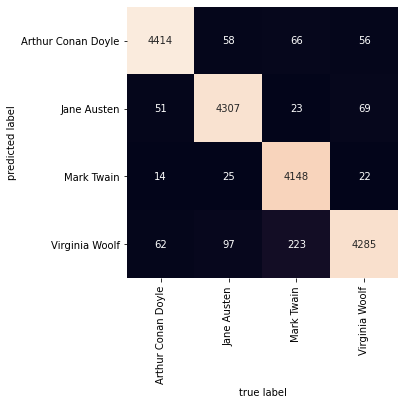

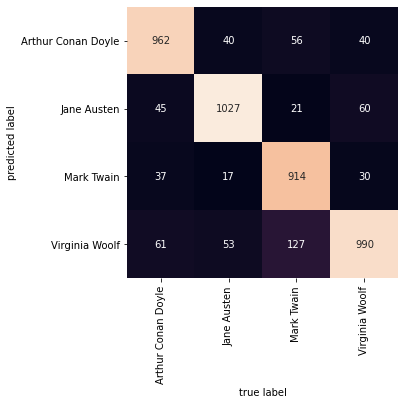

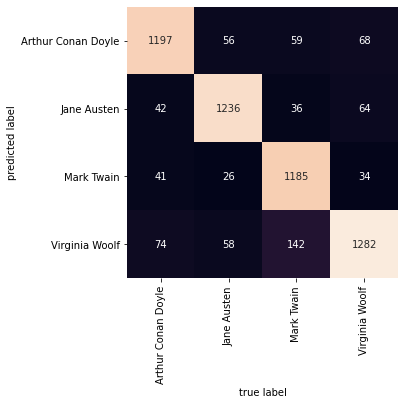

In [18]:
# Experiment 2

start_time = datetime.now()
model_1 = validation("LSTM_2",  num_epochs = 5, experiment = "{}/exp2.h5".format(path_weights))
end_time = datetime.now()
print('Duration = {}'.format(end_time - start_time))

Converted 12912 words (11219 misses)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 300)          9000000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 600)               1442400   
_________________________________________________________________
dense_4 (Dense)              (None, 300)               180300    
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_6 (Dense)  

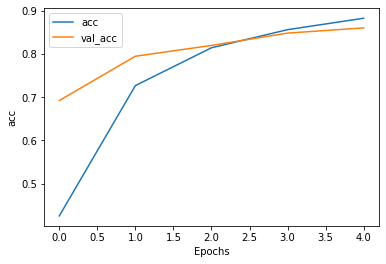

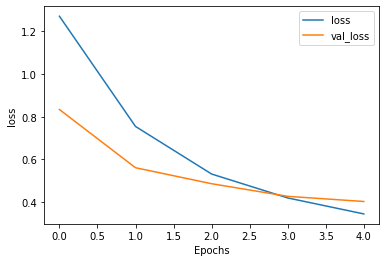

**************************************************************************
************************************* Metrics ****************************
**************************************************************************
175/175 [==============================] - 3s 15ms/step - loss: 0.4014 - acc: 0.8679
**************************************************************************
Results Training     : {'loss': 0.22548653185367584, 'acc': 0.9170758724212646}
F1 Micro Training    : 0.9170758928571429
F1 Macro Training    : 0.9177048876014854
Results Validation   : {'loss': 0.40275076031684875, 'acc': 0.8604910969734192}
F1 Micro Validation  : 0.8604910714285714
F1 Macro Validation  : 0.8613710119130056
Results Test         : {'loss': 0.40142861008644104, 'acc': 0.8678571581840515}
F1 Micro Test        : 0.8678571428571429
F1 Macro Test        : 0.869000826582115
**************************************************************************
Duration = 0:02:39.931719


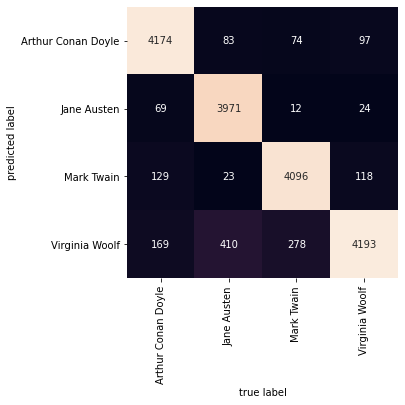

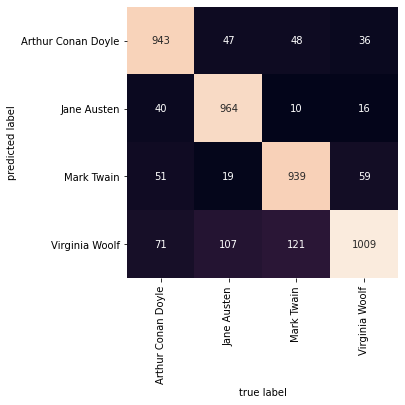

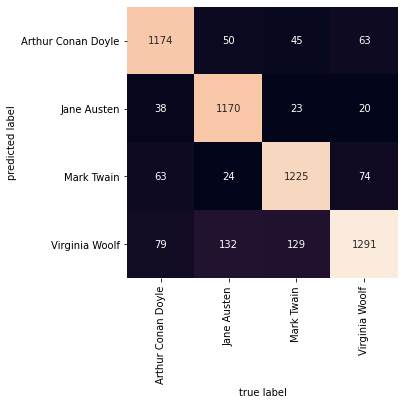

In [19]:
# Experiment 3

start_time = datetime.now()
model_1 = validation("LSTM_3",  num_epochs = 5, experiment = "{}/exp3.h5".format(path_weights))
end_time = datetime.now()
print('Duration = {}'.format(end_time - start_time))


Converted 12912 words (11219 misses)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 250, 300)          9000000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 600)               1442400   
_________________________________________________________________
dense_7 (Dense)              (None, 300)               180300    
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_3 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_9 (Dense)  

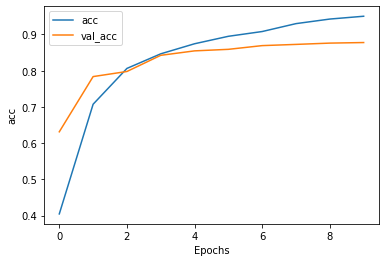

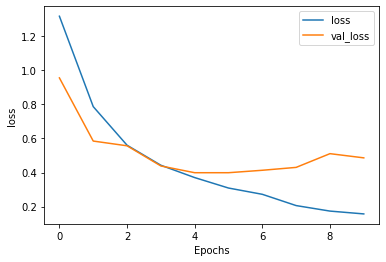

**************************************************************************
************************************* Metrics ****************************
**************************************************************************
175/175 [==============================] - 3s 15ms/step - loss: 0.4859 - acc: 0.8818
**************************************************************************
Results Training     : {'loss': 0.07199656963348389, 'acc': 0.9763392806053162}
F1 Micro Training    : 0.9763392857142857
F1 Macro Training    : 0.9763345530957954
Results Validation   : {'loss': 0.48607608675956726, 'acc': 0.8776785731315613}
F1 Micro Validation  : 0.8776785714285714
F1 Macro Validation  : 0.8778070260816218
Results Test         : {'loss': 0.48586007952690125, 'acc': 0.8817856907844543}
F1 Micro Test        : 0.8817857142857142
F1 Macro Test        : 0.882243614062239
**************************************************************************
Duration = 0:04:49.733339


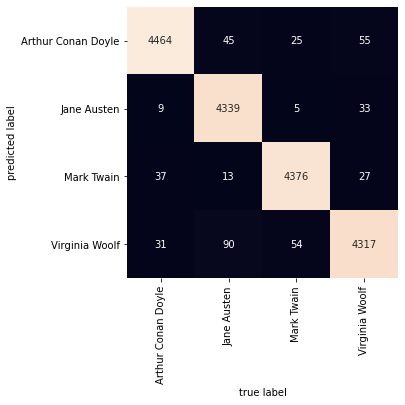

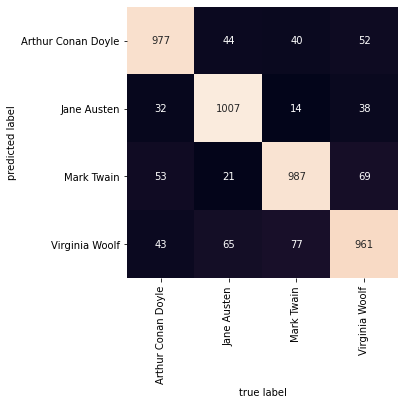

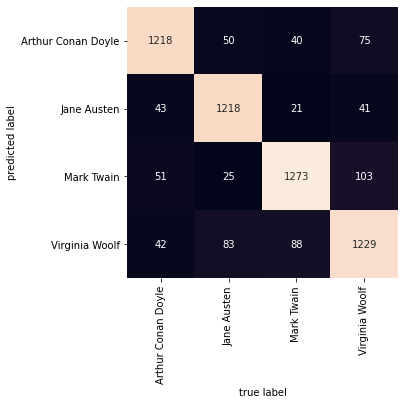

In [20]:
# Experiment 3a, epoch = 10

start_time = datetime.now()
model_1 = validation("LSTM_3",  num_epochs = 10, experiment = "{}/exp3a.h5".format(path_weights))
end_time = datetime.now()
print('Duration = {}'.format(end_time - start_time))

Converted 12912 words (11219 misses)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 250, 300)          9000000   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 600)               1442400   
_________________________________________________________________
dense_10 (Dense)             (None, 300)               180300    
_________________________________________________________________
dropout_4 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 300)               90300     
_________________________________________________________________
dropout_5 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_12 (Dense) 

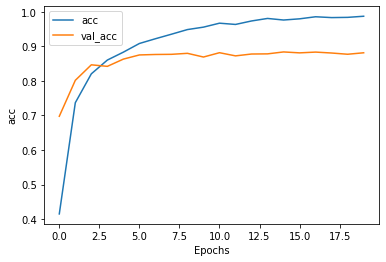

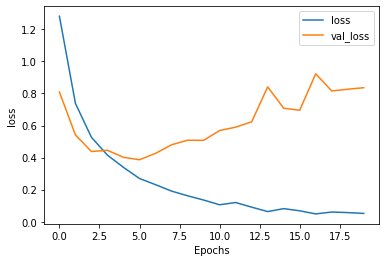

**************************************************************************
************************************* Metrics ****************************
**************************************************************************
175/175 [==============================] - 3s 15ms/step - loss: 0.8713 - acc: 0.8814
**************************************************************************
Results Training     : {'loss': 0.017452150583267212, 'acc': 0.9957589507102966}
F1 Micro Training    : 0.9957589285714286
F1 Macro Training    : 0.9957535849384336
Results Validation   : {'loss': 0.8360677361488342, 'acc': 0.8812500238418579}
F1 Micro Validation  : 0.88125
F1 Macro Validation  : 0.8810656023021826
Results Test         : {'loss': 0.8713158369064331, 'acc': 0.881428599357605}
F1 Micro Test        : 0.8814285714285715
F1 Macro Test        : 0.8816281468638587
**************************************************************************
Duration = 0:09:02.276320


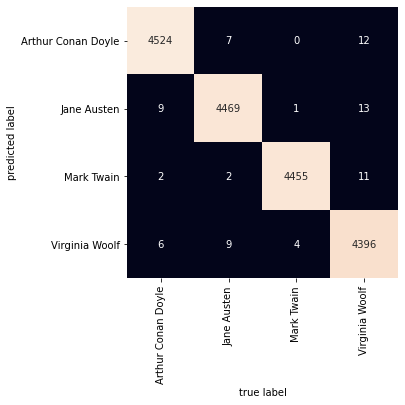

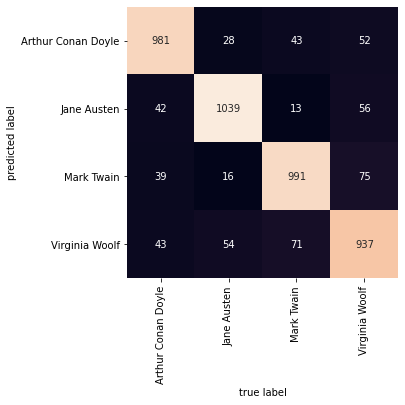

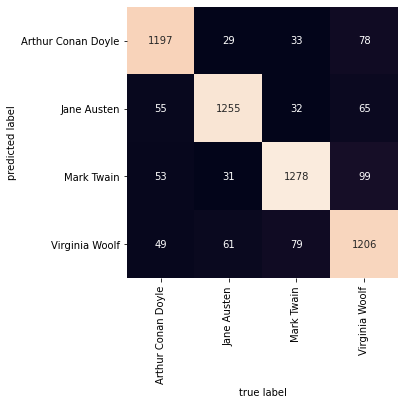

In [21]:
# Experiment 3b, epoch = 20

start_time = datetime.now()
model_1 = validation("LSTM_3",  num_epochs = 20, experiment = "{}/exp3b.h5".format(path_weights))
end_time = datetime.now()
print('Duration = {}'.format(end_time - start_time))

Converted 12912 words (11219 misses)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 250, 300)          9000000   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 600)               1442400   
_________________________________________________________________
dense_13 (Dense)             (None, 300)               180300    
_________________________________________________________________
dropout_6 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 300)               90300     
_________________________________________________________________
dropout_7 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_15 (Dense) 

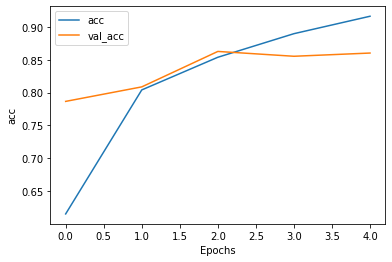

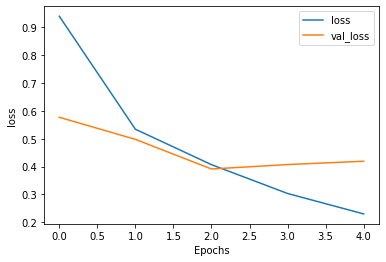

**************************************************************************
************************************* Metrics ****************************
**************************************************************************
175/175 [==============================] - 3s 15ms/step - loss: 0.4022 - acc: 0.8689
**************************************************************************
Results Training     : {'loss': 0.17961591482162476, 'acc': 0.9365513324737549}
F1 Micro Training    : 0.9365513392857143
F1 Macro Training    : 0.9366159353938095
Results Validation   : {'loss': 0.4192007780075073, 'acc': 0.8602678775787354}
F1 Micro Validation  : 0.8602678571428571
F1 Macro Validation  : 0.8605051062135078
Results Test         : {'loss': 0.40221327543258667, 'acc': 0.8689285516738892}
F1 Micro Test        : 0.8689285714285714
F1 Macro Test        : 0.8696324620994472
**************************************************************************
Duration = 0:02:40.675254


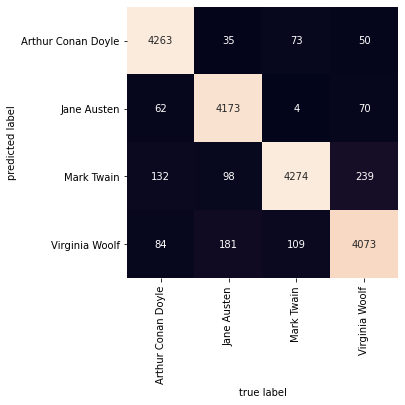

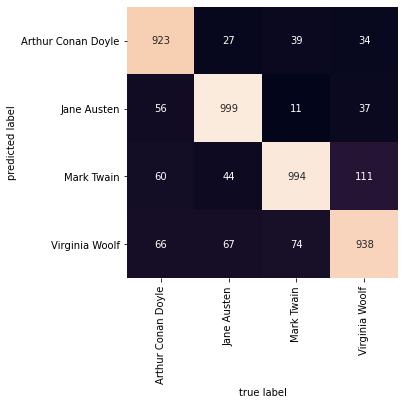

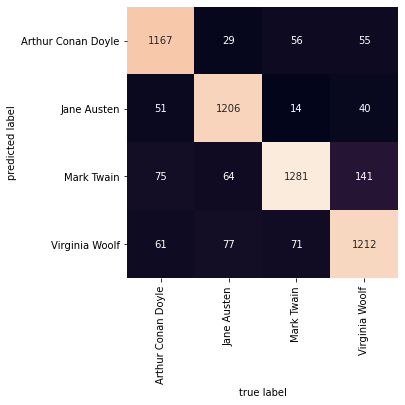

In [22]:
# Experiment 4

start_time = datetime.now()
model_1 = validation("LSTM_4",  num_epochs = 5, experiment = "{}/exp4.h5".format(path_weights))
end_time = datetime.now()
print('Duration = {}'.format(end_time - start_time))

Converted 12912 words (11219 misses)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 250, 300)          9000000   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 600)               1442400   
_________________________________________________________________
dense_16 (Dense)             (None, 300)               180300    
_________________________________________________________________
dropout_8 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 300)               90300     
_________________________________________________________________
dropout_9 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_18 (Dense) 

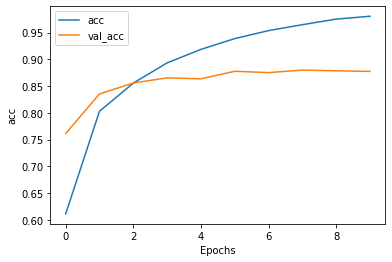

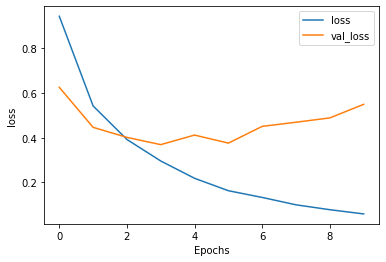

**************************************************************************
************************************* Metrics ****************************
**************************************************************************
175/175 [==============================] - 3s 15ms/step - loss: 0.4990 - acc: 0.8857
**************************************************************************
Results Training     : {'loss': 0.028800807893276215, 'acc': 0.9912946224212646}
F1 Micro Training    : 0.9912946428571429
F1 Macro Training    : 0.991281666071882
Results Validation   : {'loss': 0.5493186116218567, 'acc': 0.8774553537368774}
F1 Micro Validation  : 0.8774553571428572
F1 Macro Validation  : 0.8772739371586674
Results Test         : {'loss': 0.4990147054195404, 'acc': 0.8857142925262451}
F1 Micro Test        : 0.8857142857142857
F1 Macro Test        : 0.8861409190561957
**************************************************************************
Duration = 0:04:49.311869


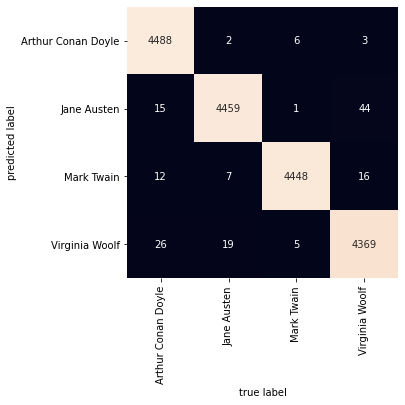

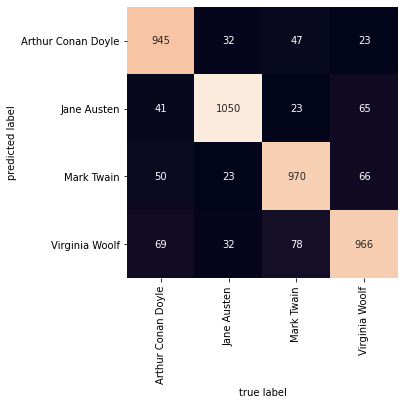

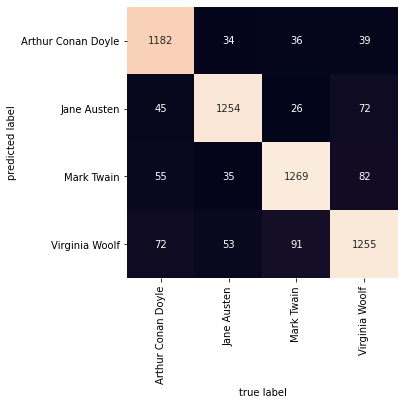

In [23]:
# Experiment 4a, epoch = 10

start_time = datetime.now()
model_1 = validation("LSTM_4",  num_epochs = 10, experiment = "{}/exp4a.h5".format(path_weights))
end_time = datetime.now()
print('Duration = {}'.format(end_time - start_time))

Converted 12912 words (11219 misses)
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 250, 300)          9000000   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 600)               1442400   
_________________________________________________________________
dense_19 (Dense)             (None, 300)               180300    
_________________________________________________________________
dropout_10 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 300)               90300     
_________________________________________________________________
dropout_11 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_21 (Dense) 

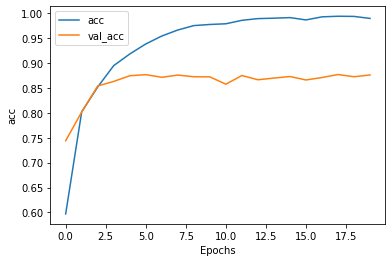

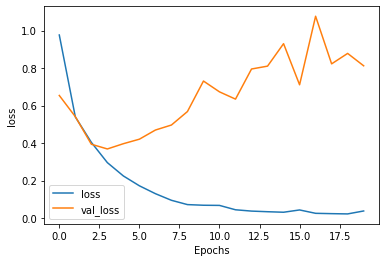

**************************************************************************
************************************* Metrics ****************************
**************************************************************************
175/175 [==============================] - 3s 16ms/step - loss: 0.8472 - acc: 0.8748
**************************************************************************
Results Training     : {'loss': 0.014704624190926552, 'acc': 0.9952567219734192}
F1 Micro Training    : 0.9952566964285714
F1 Macro Training    : 0.9952489058898857
Results Validation   : {'loss': 0.8120054006576538, 'acc': 0.8758928775787354}
F1 Micro Validation  : 0.8758928571428573
F1 Macro Validation  : 0.8758454991923839
Results Test         : {'loss': 0.8471549153327942, 'acc': 0.8748214244842529}
F1 Micro Test        : 0.8748214285714285
F1 Macro Test        : 0.8748729338412056
**************************************************************************
Duration = 0:09:06.906436


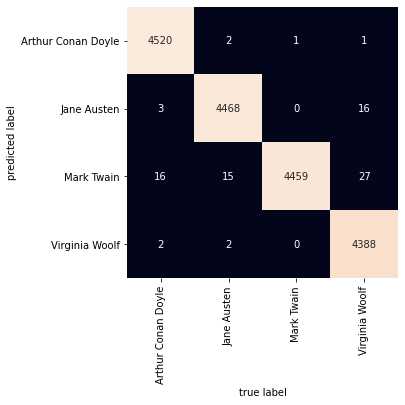

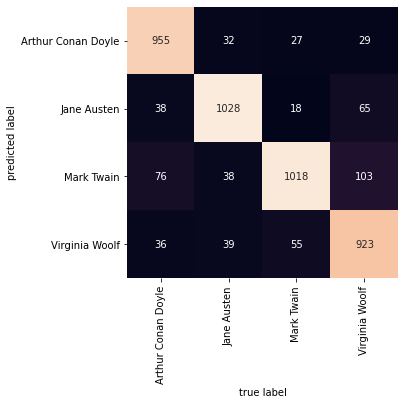

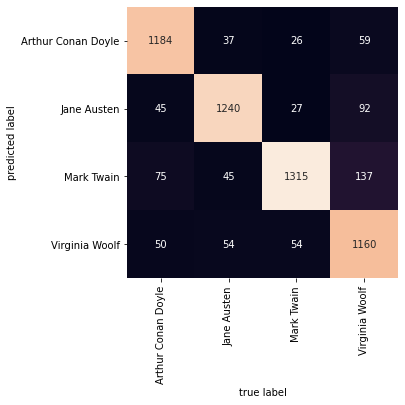

In [24]:
# Experiment 4b, epoch = 20

start_time = datetime.now()
model_1 = validation("LSTM_4",  num_epochs = 20, experiment = "{}/exp4b.h5".format(path_weights))
end_time = datetime.now()
print('Duration = {}'.format(end_time - start_time))

# Predicitng

In [25]:
trans = {1: 'Arthur Conan Doyle', 2: 'Jane Austen', 3: 'Mark twain', 4: 'Virginia Woolf'}

# predictions=model_1.predict([xtest_pad])
# author_prediction = np.argmax(predictions,axis=-1)
# print(author_prediction)

# Mark Twain: letters from the earth
doc_mt_1 = "As you have seen, that singular show is a service of praise: praise by hymn, praise by prostration. It takes the place of church.  Now then, in the earth these people cannot stand much church -- an hour and a quarter is the limit, and they draw the line at once a week. That is to say, Sunday. One day in seven; and even then they do not look forward to it with longing. And so -- consider what their heaven provides for them: church that lasts forever, and a Sabbath that has no end! They quickly weary of this brief hebdomadal Sabbath here, yet they long for that eternal one; they dream of it, they talk about it, they think they think they are going to enjoy it -- with all their simple hearts they think they think they are going to be happy in it! "

result = model_1.predict_on_batch(sequence.pad_sequences(tokenizer_train.texts_to_sequences([doc_mt_1]),maxlen=250))
author_prediction = np.argmax(result,axis=-1)
print(trans.get(author_prediction[0]))

Virginia Woolf
